<!-- docusaurus_head_meta::start
---
title: Use an LLM to tag and caption images
---
docusaurus_head_meta::end -->

<!--- @wandbcode{cod-notebook} -->

*Adapted from the OpenAI Cookbook "[Using GPT4o mini to tag and caption images](https://cookbook.openai.com/examples/tag_caption_images_with_gpt4v)"*

# Use an LLM to tag & caption images

This notebook explores how to leverage the vision capabilities of the GPT-4* models (for example `gpt-4o`, `gpt-4o-mini` or `gpt-4-turbo`) to tag & caption images. 

We can leverage the multimodal capabilities of these models to provide input images along with additional context on what they represent, and prompt the model to output tags or image descriptions. The image descriptions can then be further refined with a language model (in this notebook, we'll use `gpt-4o-mini`) to generate captions. 

Generating text content from images can be useful for multiple use cases, especially use cases involving search.  
We will illustrate a search use case in this notebook by using generated keywords and product captions to search for products - both from a text input and an image input.

As an example, we will use a dataset of Amazon furniture items, tag them with relevant keywords and generate short, descriptive captions.

## Setup

In [1]:
# Install dependencies if needed
%pip install --quiet openai scikit-learn pandas pillow
%pip install --quiet weave


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython.display import display
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from openai import OpenAI

# Initializing OpenAI client - see https://platform.openai.com/docs/quickstart?context=python
# Define the OPENAI_API_KEY environment variable to simplify the initialization
client = OpenAI()

In [3]:
# Loading dataset
import weave

# Retrieve the dataset
dataset = weave.ref(
    "weave:///team-jdoc/tag_caption_images/object/Amazon-Furniture-Dataset:latest"
).get()
df = pd.DataFrame(dataset.rows)
df.head()

,asin,url,title,brand,price,availability,categories,primary_image,images,upc,...,color,material,style,important_information,product_overview,about_item,description,specifications,uniq_id,scraped_at
0,B0CJHKVG6P,https://www.amazon.com/dp/B0CJHKVG6P,"GOYMFK 1pc Free Standing Shoe Rack, Multi-laye...",GOYMFK,$24.99,Only 13 left in stock - order soon.,"['Home & Kitchen', 'Storage & Organization', '...",https://m.media-amazon.com/images/I/416WaLx10j...,['https://m.media-amazon.com/images/I/416WaLx1...,,...,White,Metal,Modern,[],"[{'Brand': ' GOYMFK '}, {'Color': ' White '}, ...",['Multiple layers: Provides ample storage spac...,"multiple shoes, coats, hats, and other items E...","['Brand: GOYMFK', 'Color: White', 'Material: M...",02593e81-5c09-5069-8516-b0b29f439ded,2024-02-02 15:15:08
1,B0B66QHB23,https://www.amazon.com/dp/B0B66QHB23,"subrtex Leather ding Room, Dining Chairs Set o...",subrtex,,,"['Home & Kitchen', 'Furniture', 'Dining Room F...",https://m.media-amazon.com/images/I/31SejUEWY7...,['https://m.media-amazon.com/images/I/31SejUEW...,,...,Black,Sponge,Black Rubber Wood,[],,['【Easy Assembly】: Set of 2 dining room chairs...,subrtex Dining chairs Set of 2,"['Brand: subrtex', 'Color: Black', 'Product Di...",5938d217-b8c5-5d3e-b1cf-e28e340f292e,2024-02-02 15:15:09
2,B0BXRTWLYK,https://www.amazon.com/dp/B0BXRTWLYK,Plant Repotting Mat MUYETOL Waterproof Transpl...,MUYETOL,$5.98,In Stock,"['Patio, Lawn & Garden', 'Outdoor Décor', 'Doo...",https://m.media-amazon.com/images/I/41RgefVq70...,['https://m.media-amazon.com/images/I/41RgefVq...,,...,Green,Polyethylene,Modern,[],"[{'Brand': ' MUYETOL '}, {'Size': ' 26.8*26.8 ...","['PLANT REPOTTING MAT SIZE: 26.8"" x 26.8"", squ...",,"['Brand: MUYETOL', 'Size: 26.8*26.8', 'Item We...",b2ede786-3f51-5a45-9a5b-bcf856958cd8,2024-02-02 15:15:09
3,B0C1MRB2M8,https://www.amazon.com/dp/B0C1MRB2M8,"Pickleball Doormat, Welcome Doormat Absorbent ...",VEWETOL,$13.99,Only 10 left in stock - order soon.,"['Patio, Lawn & Garden', 'Outdoor Décor', 'Doo...",https://m.media-amazon.com/images/I/61vz1Igler...,['https://m.media-amazon.com/images/I/61vz1Igl...,,...,A5589,Rubber,Modern,[],"[{'Brand': ' VEWETOL '}, {'Size': ' 16*24INCH ...","['Specifications: 16x24 Inch ', "" High-Quality...",The decorative doormat features a subtle textu...,"['Brand: VEWETOL', 'Size: 16*24INCH', 'Materia...",8fd9377b-cfa6-5f10-835c-6b8eca2816b5,2024-02-02 15:15:10
4,B0CG1N9QRC,https://www.amazon.com/dp/B0CG1N9QRC,JOIN IRON Foldable TV Trays for Eating Set of ...,JOIN IRON Store,$89.99,Usually ships within 5 to 6 weeks,"['Home & Kitchen', 'Furniture', 'Game & Recrea...",https://m.media-amazon.com/images/I/41p4d4VJnN...,['https://m.media-amazon.com/images/I/41p4d4VJ...,,...,Grey Set of 4,Iron,X Classic Style,[],,['Includes 4 Folding Tv Tray Tables And one Co...,Set of Four Folding Trays With Matching Storag...,"['Brand: JOIN IRON', 'Shape: Rectangular', 'In...",bdc9aa30-9439-50dc-8e89-213ea211d66a,2024-02-02 15:15:11


## Tag images

In this section, we'll use GPT-4o mini to generate relevant tags for our products.

We'll use a simple zero-shot approach to extract keywords, and deduplicate those keywords using embeddings to avoid having multiple keywords that are too similar.

We will use a combination of an image and the product title to avoid extracting keywords for other items that are depicted in the image - sometimes there are multiple items used in the scene and we want to focus on just the one we want to tag.

### Extract keywords

In [4]:
import requests
from PIL import Image
from io import BytesIO

def get_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

system_prompt = '''
    You are an agent specialized in tagging images of furniture items, decorative items, or furnishings with relevant keywords that could be used to search for these items on a marketplace.
    
    You will be provided with an image and the title of the item that is depicted in the image, and your goal is to extract keywords for only the item specified. 
    
    Keywords should be concise and in lower case. 
    
    Keywords can describe things like:
    - Item type e.g. 'sofa bed', 'chair', 'desk', 'plant'
    - Item material e.g. 'wood', 'metal', 'fabric'
    - Item style e.g. 'scandinavian', 'vintage', 'industrial'
    - Item color e.g. 'red', 'blue', 'white'
    
    Only deduce material, style or color keywords when it is obvious that they make the item depicted in the image stand out.

    Return keywords in the format of an array of strings, like this:
    ['desk', 'industrial', 'metal']
    
'''

@weave.op
def gen_keywords(img_url, title):
    response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": img_url,
                    }
                },
            ],
        },
        {
            "role": "user",
            "content": title
        }
    ],
        max_tokens=300,
        top_p=0.1
    )

    # return response.choices[0].message.content
    return {"keywords": response.choices[0].message.content, "image": get_image(img_url)}

#### Testing with a few examples

In [5]:
examples = df.iloc[-5:]

Logged in as Weights & Biases user: iamjdoc.
View Weave data at https://wandb.ai/team-jdoc/tag_caption_images/weave
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b780-e82b-77b0-a4bf-144f1499270b


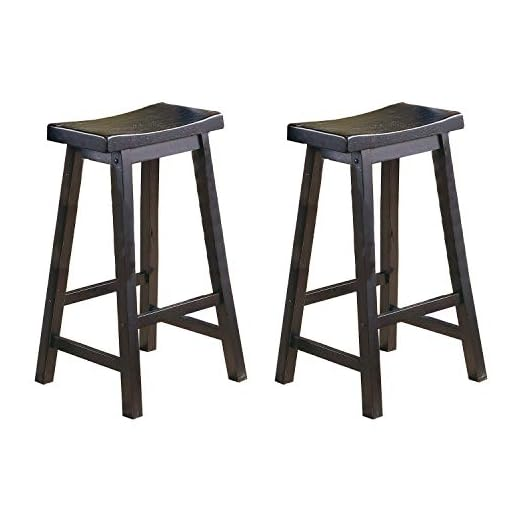

['bar stools', 'wood', 'black', 'saddle']



🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b780-f65e-7703-bad7-745f92c3ad13


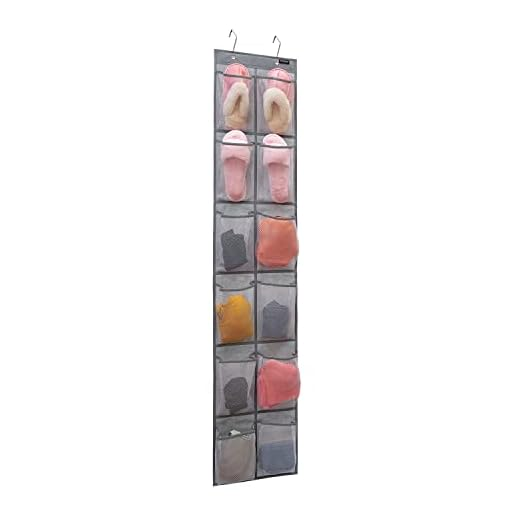

['shoe organizer', 'hanging', 'mesh', 'closet', 'storage', 'kids', 'pockets']



🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b781-04d1-7ca3-bbd4-204ce012539e


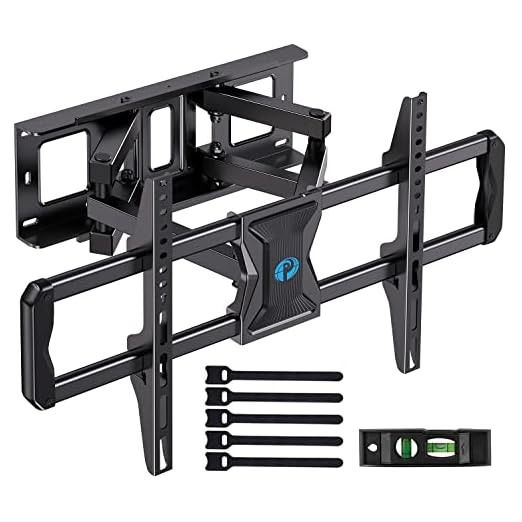

['tv wall mount', 'full-motion', 'metal', 'black']



🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b781-1d1f-7682-a4f3-7d8a64b7a124


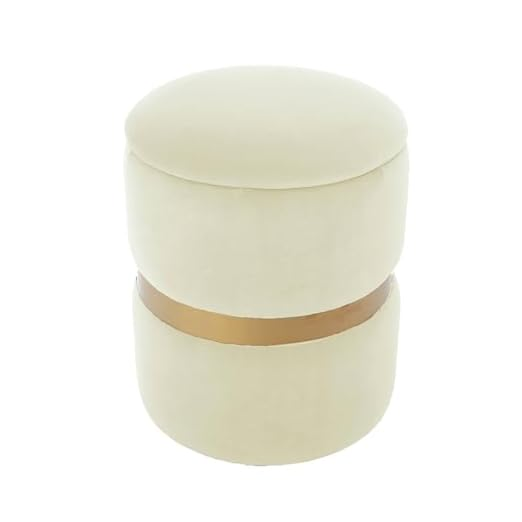

['ottoman', 'storage', 'velvet', 'ivory', 'modern']



🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b781-2bb1-73d0-b613-b9e9c661c292


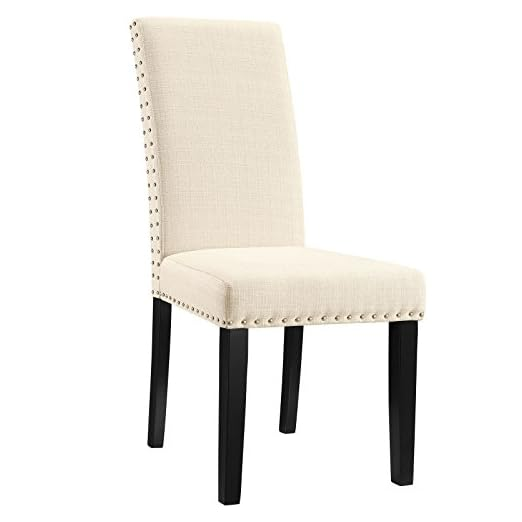

['chair', 'upholstered', 'fabric', 'beige', 'parsons']





In [6]:
# Initialize tracing with weave
weave.init("tag_caption_images")

for index, ex in examples.iterrows():
    url = ex['primary_image']
    results = gen_keywords(url, ex['title'])
    display(results["image"])
    print(results["keywords"])
    print("\n\n")

### Looking up existing keywords

Using embeddings to avoid duplicates (synonyms) and/or match pre-defined keywords

In [7]:
# Feel free to change the embedding model here
# @weave.op
def get_embedding(value, model="text-embedding-3-large"): 
    embeddings = client.embeddings.create(
      model=model,
      input=value,
      encoding_format="float"
    )
    return {"embedding": embeddings.data[0].embedding}

#### Testing with example keywords

In [8]:
# Existing keywords
keywords_list = ["industrial", "metal", "wood", "vintage", "bed"]

In [9]:
from weave import Dataset

keywords_embeddings = []
for keyword in keywords_list:
    item = {"embedding": get_embedding(keyword)["embedding"], "keyword": keyword}
    keywords_embeddings.append(item)

weave.publish(Dataset(name="keywords_embeddings", rows=keywords_embeddings))

📦 Published to https://wandb.ai/team-jdoc/tag_caption_images/weave/objects/keywords_embeddings/versions/lfCInmmloy8KSa49QHcG5BgXpFT7ro9YOOGe5MEXDEo


ObjectRef(entity='team-jdoc', project='tag_caption_images', name='keywords_embeddings', _digest='lfCInmmloy8KSa49QHcG5BgXpFT7ro9YOOGe5MEXDEo', _extra=())

In [10]:
@weave.op
def compare_keyword(keyword, embeddings_ref):
    df_keywords = pd.DataFrame(embeddings_ref.get().rows)
    embedded_value = get_embedding(keyword)["embedding"]
    df_keywords['similarity'] = df_keywords['embedding'].apply(lambda x: cosine_similarity(np.array(x).reshape(1,-1), np.array(embedded_value).reshape(1, -1)))
    most_similar = df_keywords.sort_values('similarity', ascending=False).iloc[0]
    most_similar["similarity"] = most_similar["similarity"][0][0]
    return {
        "embedding": most_similar["embedding"],
        "keyword": most_similar["keyword"],
        "similarity": most_similar["similarity"]
    }


@weave.op
def replace_keyword(keyword, embeddings_ref, threshold=0.6):
    most_similar = compare_keyword(keyword, embeddings_ref)
    if most_similar['similarity'] > threshold:
        print(f"Replacing '{keyword}' with existing keyword: '{most_similar['keyword']}'")
        return {"keyword": most_similar['keyword']}
    return {"keyword": keyword}

In [11]:
# Example keywords to compare to our list of existing keywords
example_keywords = ['bed frame', 'wooden', 'vintage', 'old school', 'desk', 'table', 'old', 'metal', 'metallic', 'woody']
final_keywords = []

for k in example_keywords:
    final_keywords.append(
        replace_keyword(k, weave.ref("keywords_embeddings:latest"))["keyword"]
    )

final_keywords = set(final_keywords)
print(f"Final keywords: {final_keywords}")

Replacing 'bed frame' with existing keyword: 'bed'
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b781-41d8-79d1-bec2-4e2f016c738b
Replacing 'wooden' with existing keyword: 'wood'
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b781-46ce-7922-b392-32f8c7f89fc6
Replacing 'vintage' with existing keyword: 'vintage'
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b781-4b8e-76d1-9d75-57bf16a476be
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b781-4fd7-7b31-a751-08a261f54160
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b781-5458-7e71-99f9-92209366c147
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b781-5987-7523-b005-0e0febe674ab
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b781-5db9-7430-a511-6f77131f93ab
Replacing 'metal' with existing keyword: 'metal'
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b781-6262-7670-98e7-e9fa3a6ab2ee
Replacing 'metallic' with existing keyword: 'metal'
🍩 https://

## Generate captions

In this section, we'll use GPT-4o mini to generate an image description and then use a few-shot examples approach with GPT-4-turbo to generate captions from the images.

If few-shot examples are not enough for your use case, consider fine-tuning a model to get the generated captions to match the style & tone you are targeting. 

In [12]:
# Cleaning up dataset columns
selected_columns = ['title', 'primary_image', 'style', 'material', 'color', 'url']
df = df[selected_columns].copy()
df.head()

,title,primary_image,style,material,color,url
0,"GOYMFK 1pc Free Standing Shoe Rack, Multi-laye...",https://m.media-amazon.com/images/I/416WaLx10j...,Modern,Metal,White,https://www.amazon.com/dp/B0CJHKVG6P
1,"subrtex Leather ding Room, Dining Chairs Set o...",https://m.media-amazon.com/images/I/31SejUEWY7...,Black Rubber Wood,Sponge,Black,https://www.amazon.com/dp/B0B66QHB23
2,Plant Repotting Mat MUYETOL Waterproof Transpl...,https://m.media-amazon.com/images/I/41RgefVq70...,Modern,Polyethylene,Green,https://www.amazon.com/dp/B0BXRTWLYK
3,"Pickleball Doormat, Welcome Doormat Absorbent ...",https://m.media-amazon.com/images/I/61vz1Igler...,Modern,Rubber,A5589,https://www.amazon.com/dp/B0C1MRB2M8
4,JOIN IRON Foldable TV Trays for Eating Set of ...,https://m.media-amazon.com/images/I/41p4d4VJnN...,X Classic Style,Iron,Grey Set of 4,https://www.amazon.com/dp/B0CG1N9QRC


### Describing images with GPT-4o mini

In [13]:
describe_system_prompt = '''
    You are a system generating descriptions for furniture items, decorative items, or furnishings on an e-commerce website.
    Provided with an image and a title, you will describe the main item that you see in the image, giving details but staying concise.
    You can describe unambiguously what the item is and its material, color, and style if clearly identifiable.
    If there are multiple items depicted, refer to the title to understand which item you should describe.
    '''

@weave.op
def describe_image(img_url, title):
    response = client.chat.completions.create(
    model="gpt-4o-mini",
    temperature=0.2,
    messages=[
        {
            "role": "system",
            "content": describe_system_prompt
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": img_url,
                    }
                },
            ],
        },
        {
            "role": "user",
            "content": title
        }
    ],
    max_tokens=300,
    )

    return {"description": response.choices[0].message.content}

#### Testing on a few examples

In [14]:
for index, row in examples.iterrows():
    print(f"{row['title'][:50]}{'...' if len(row['title']) > 50 else ''} - {row['url']} :")
    result = describe_image(row['primary_image'], row['title'])
    print(f"{result}\n--------------------------\n")

Lexicon Victoria Saddle Wood Bar Stools (Set of 2)... - https://www.amazon.com/dp/B08SLPBC36 :
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b781-7094-7fd2-a7db-836b7d1c6d91
{'description': 'The Lexicon Victoria Saddle Wood Bar Stools are a stylish set of two, featuring a sleek black sand finish. Each stool stands at a height of 28.5 inches, making them ideal for bar or counter seating. The saddle-shaped seat design provides comfort, while the sturdy wooden construction ensures durability. The minimalist style complements various decor themes, adding a modern touch to your space.'}
--------------------------

ANZORG Behind Door Hanging Kids Shoes Organizer Cl... - https://www.amazon.com/dp/B09KN5ZTXC :
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b781-7fbe-7061-9439-669e4b3ec147
{'description': "The ANZORG Behind Door Hanging Kids Shoes Organizer features a vertical design with 12 mesh pockets, ideal for storing shoes and other small items. The organizer is m

### Turning descriptions into captions
Using a few-shot examples approach to turn a long description into a short image caption

In [15]:
caption_system_prompt = '''
Your goal is to generate short, descriptive captions for images of furniture items, decorative items, or furnishings based on an image description.
You will be provided with a description of an item image and you will output a caption that captures the most important information about the item.
Your generated caption should be short (1 sentence), and include the most relevant information about the item.
The most important information could be: the type of the item, the style (if mentioned), the material if especially relevant and any distinctive features.
'''

few_shot_examples = [
    {
        "description": "This is a multi-layer metal shoe rack featuring a free-standing design. It has a clean, white finish that gives it a modern and versatile look, suitable for various home decors. The rack includes several horizontal shelves dedicated to organizing shoes, providing ample space for multiple pairs. Above the shoe storage area, there are 8 double hooks arranged in two rows, offering additional functionality for hanging items such as hats, scarves, or bags. The overall structure is sleek and space-saving, making it an ideal choice for placement in living rooms, bathrooms, hallways, or entryways where efficient use of space is essential.",
        "caption": "White metal free-standing shoe rack"
    },
    {
        "description": "The image shows a set of two dining chairs in black. These chairs are upholstered in a leather-like material, giving them a sleek and sophisticated appearance. The design features straight lines with a slight curve at the top of the high backrest, which adds a touch of elegance. The chairs have a simple, vertical stitching detail on the backrest, providing a subtle decorative element. The legs are also black, creating a uniform look that would complement a contemporary dining room setting. The chairs appear to be designed for comfort and style, suitable for both casual and formal dining environments.",
        "caption": "Set of 2 modern black leather dining chairs"
    },
    {
        "description": "This is a square plant repotting mat designed for indoor gardening tasks such as transplanting and changing soil for plants. It measures 26.8 inches by 26.8 inches and is made from a waterproof material, which appears to be a durable, easy-to-clean fabric in a vibrant green color. The edges of the mat are raised with integrated corner loops, likely to keep soil and water contained during gardening activities. The mat is foldable, enhancing its portability, and can be used as a protective surface for various gardening projects, including working with succulents. It's a practical accessory for garden enthusiasts and makes for a thoughtful gift for those who enjoy indoor plant care.",
        "caption": "Waterproof square plant repotting mat"
    }
]

formatted_examples = [[{
    "role": "user",
    "content": ex['description']
},
{
    "role": "assistant", 
    "content": ex['caption']
}]
    for ex in few_shot_examples
]

formatted_examples = [i for ex in formatted_examples for i in ex]
for item in formatted_examples:
    print(item)


{'role': 'user', 'content': 'This is a multi-layer metal shoe rack featuring a free-standing design. It has a clean, white finish that gives it a modern and versatile look, suitable for various home decors. The rack includes several horizontal shelves dedicated to organizing shoes, providing ample space for multiple pairs. Above the shoe storage area, there are 8 double hooks arranged in two rows, offering additional functionality for hanging items such as hats, scarves, or bags. The overall structure is sleek and space-saving, making it an ideal choice for placement in living rooms, bathrooms, hallways, or entryways where efficient use of space is essential.'}
{'role': 'assistant', 'content': 'White metal free-standing shoe rack'}
{'role': 'user', 'content': 'The image shows a set of two dining chairs in black. These chairs are upholstered in a leather-like material, giving them a sleek and sophisticated appearance. The design features straight lines with a slight curve at the top of 

In [17]:
@weave.op
def caption_image(formatted_examples, description: str, model="gpt-4o-mini"):
    messages = formatted_examples
    messages.insert(0, 
        {
            "role": "system",
            "content": caption_system_prompt
        })
    messages.append(
        {
            "role": "user",
            "content": description
        })
    response = client.chat.completions.create(
    model=model,
    temperature=0.2,
    messages=messages
    )

    return {
        "caption": response.choices[0].message.content,
        "message_count": len(messages),
    }

#### Testing on a few examples

In [18]:
examples = df.iloc[5:8]

In [19]:
for index, row in examples.iterrows():
    print(f"{row['title'][:50]}{'...' if len(row['title']) > 50 else ''} - {row['url']} :")
    result = describe_image(row["primary_image"], row["title"])
    print(f"{result}")
    img_caption = caption_image(formatted_examples, result["description"])
    print(f"{img_caption}\n--------------------------\n")

LOVMOR 30'' Bathroom Vanity Sink Base Cabine, Stor... - https://www.amazon.com/dp/B0C9WYYFLB :
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b782-3408-7161-9cb3-f109a971f85a
{'description': "The LOVMOR 30'' Bathroom Vanity Sink Base Cabinet features a classic design with a rich brown finish. It includes three drawers on the left side for ample storage, complemented by two larger cabinet doors on the right. The cabinet is crafted with a detailed panel design, adding elegance to any bathroom, kitchen, or laundry room. Its sturdy construction ensures durability while providing a stylish and functional storage solution."}
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b782-5542-7e82-954e-0610046ce97f
{'caption': "Classic 30'' brown bathroom vanity sink base cabinet with three drawers and two cabinet doors.", 'message_count': 8}
--------------------------

Folews Bathroom Organizer Over The Toilet Storage,... - https://www.amazon.com/dp/B09NZY3R1T :
🍩 https://wandb.

## Image search

In this section, we will use generated keywords and captions to search items that match a given input, either text or image.

We will leverage our embeddings model to generate embeddings for the keywords and captions and compare them to either input text or the generated caption from an input image.

In [20]:
# Df we'll use to compare keywords
df['keywords'] = ''
df['img_description'] = ''
df['caption'] = ''
df.head()

,title,primary_image,style,material,color,url,keywords,img_description,caption
0,"GOYMFK 1pc Free Standing Shoe Rack, Multi-laye...",https://m.media-amazon.com/images/I/416WaLx10j...,Modern,Metal,White,https://www.amazon.com/dp/B0CJHKVG6P,,,
1,"subrtex Leather ding Room, Dining Chairs Set o...",https://m.media-amazon.com/images/I/31SejUEWY7...,Black Rubber Wood,Sponge,Black,https://www.amazon.com/dp/B0B66QHB23,,,
2,Plant Repotting Mat MUYETOL Waterproof Transpl...,https://m.media-amazon.com/images/I/41RgefVq70...,Modern,Polyethylene,Green,https://www.amazon.com/dp/B0BXRTWLYK,,,
3,"Pickleball Doormat, Welcome Doormat Absorbent ...",https://m.media-amazon.com/images/I/61vz1Igler...,Modern,Rubber,A5589,https://www.amazon.com/dp/B0C1MRB2M8,,,
4,JOIN IRON Foldable TV Trays for Eating Set of ...,https://m.media-amazon.com/images/I/41p4d4VJnN...,X Classic Style,Iron,Grey Set of 4,https://www.amazon.com/dp/B0CG1N9QRC,,,


In [21]:
# Function to replace a keyword with an existing keyword if it's too similar
@weave.op
def get_keyword(keyword, embeddings_ref, threshold=0.6):
    embedded_value = get_embedding(keyword)["embedding"]
    df_keywords = pd.DataFrame(embeddings_ref.get().rows)
    df_keywords['similarity'] = df_keywords['embedding'].apply(lambda x: cosine_similarity(np.array(x).reshape(1,-1), np.array(embedded_value).reshape(1, -1)))
    sorted_keywords = df_keywords.copy().sort_values('similarity', ascending=False)
    if len(sorted_keywords) > 0 :
        most_similar = sorted_keywords.iloc[0]
        if most_similar['similarity'] > threshold:
            print(f"Replacing '{keyword}' with existing keyword: '{most_similar['keyword']}'")
            return {"keyword": most_similar['keyword']}
    new_keyword = {
        'keyword': keyword,
        'embedding': embedded_value
    }
    df_keywords = pd.concat([df_keywords, pd.DataFrame([new_keyword])], ignore_index=True)
    return {"keyword": keyword}

### Preparing the dataset

In [22]:
import ast


@weave.op
def tag_and_caption(row, embeddings_ref):
    df_keywords = pd.DataFrame(embeddings_ref.get().rows)
    keywords = gen_keywords(row["primary_image"], row["title"])["keywords"]
    try:
        keywords = ast.literal_eval(keywords.strip())
        mapped_keywords = [
            get_keyword(k, weave.ref("keywords_embeddings:latest"))["keyword"]
            for k in keywords
        ]
    except Exception as e:
        print(f"Error parsing keywords: {keywords}")
        mapped_keywords = []
    img_description = describe_image(row['primary_image'], row['title'])["description"]
    caption = caption_image(formatted_examples, img_description)["caption"]
    return {
        'keywords': mapped_keywords,
        'img_description': img_description,
        'caption': caption
    }

In [23]:
df.shape

(312, 9)

Processing all 312 lines of the dataset will take a while.
To test out the idea, we will only run it on the first 5 lines. 
Feel free to skip this step and load the already processed dataset (see below).

In [24]:
# Running on first 5 lines
for index, row in df[:5].iterrows():
    print(
        f"{index} - {row['title'][:50]}{'...' if len(row['title']) > 50 else ''}"
    )
    updates = tag_and_caption(row, weave.ref("keywords_embeddings:latest"))
    df.loc[index, updates.keys()] = updates.values()

0 - GOYMFK 1pc Free Standing Shoe Rack, Multi-layer Me...
Replacing 'metal' with existing keyword: 'metal'
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b782-79e3-7001-9da5-7f356fb041b4
1 - subrtex Leather ding Room, Dining Chairs Set of 2,...
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b782-afca-72a2-9f1c-d69eed7a3079
2 - Plant Repotting Mat MUYETOL Waterproof Transplanti...
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b782-e1c0-7d43-b326-cdaf1b15367f
3 - Pickleball Doormat, Welcome Doormat Absorbent Non-...
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b783-3006-7e12-a6ff-0a9ae96068c4
4 - JOIN IRON Foldable TV Trays for Eating Set of 4 wi...
Replacing 'metal' with existing keyword: 'metal'
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b783-7c25-7c83-829f-65d4643c47ff


In [25]:
# Save to weave - optional: uncomment if you processed the whole dataset
# weave.publish(
#     Dataset(name="Tagged-and-Captioned-Items", rows=df.to_dict(orient="records"))
# )

In [26]:
# Load data from weave
df = weave.ref("Tagged-and-Captioned-Items:latest").get()
df = pd.DataFrame(df.rows)
df.head()

,title,primary_image,style,material,color,url,keywords,img_description,caption
0,"GOYMFK 1pc Free Standing Shoe Rack, Multi-laye...",https://m.media-amazon.com/images/I/416WaLx10j...,Modern,Metal,White,https://www.amazon.com/dp/B0CJHKVG6P,"['shoe rack', 'free standing', 'multi-layer', ...",This is a free-standing shoe rack featuring a ...,White metal free-standing shoe rack with multi...
1,"subrtex Leather ding Room, Dining Chairs Set o...",https://m.media-amazon.com/images/I/31SejUEWY7...,Black Rubber Wood,Sponge,Black,https://www.amazon.com/dp/B0B66QHB23,"['dining chairs', 'set of 2', 'leather', 'black']",This image features a set of two black dining ...,Set of 2 sleek black faux leather dining chair...
2,Plant Repotting Mat MUYETOL Waterproof Transpl...,https://m.media-amazon.com/images/I/41RgefVq70...,Modern,Polyethylene,Green,https://www.amazon.com/dp/B0BXRTWLYK,"['plant repotting mat', 'waterproof', 'portabl...",This is a square plant repotting mat designed ...,Waterproof green square plant repotting mat
3,"Pickleball Doormat, Welcome Doormat Absorbent ...",https://m.media-amazon.com/images/I/61vz1Igler...,Modern,Rubber,A5589,https://www.amazon.com/dp/B0C1MRB2M8,"['doormat', 'absorbent', 'non-slip', 'brown']",This is a rectangular doormat featuring a play...,Pickleball-themed coir doormat with playful de...
4,JOIN IRON Foldable TV Trays for Eating Set of ...,https://m.media-amazon.com/images/I/41p4d4VJnN...,X Classic Style,Iron,Grey Set of 4,https://www.amazon.com/dp/B0CG1N9QRC,"['tv tray table set', 'foldable', 'iron', 'grey']",This image showcases a set of two foldable TV ...,Set of two foldable TV trays with grey wood gr...


### Embedding captions and keywords
We can now use the generated captions and keywords to match relevant content to an input text query or caption. 
To do this, we will embed a combination of keywords + captions.
Note: creating the embeddings will take ~3 mins to run. Feel free to load the pre-processed dataset (see below).

In [27]:
df_search = df.copy()

In [28]:
def embed_tags_caption(x):
    if x['caption'] != '':
        try:
            keywords_string = ",".join(k for k in x['keywords']) + '\n'
            content = keywords_string + x['caption']
            embedding = get_embedding(content)
            return embedding
        except Exception as e:
            print(f"Error creating embedding for {x}: {e}")

In [29]:
df_search['embedding'] = df_search.apply(lambda x: embed_tags_caption(x), axis=1)

In [30]:
df_search.head()

,title,primary_image,style,material,color,url,keywords,img_description,caption,embedding
0,"GOYMFK 1pc Free Standing Shoe Rack, Multi-laye...",https://m.media-amazon.com/images/I/416WaLx10j...,Modern,Metal,White,https://www.amazon.com/dp/B0CJHKVG6P,"['shoe rack', 'free standing', 'multi-layer', ...",This is a free-standing shoe rack featuring a ...,White metal free-standing shoe rack with multi...,"{'embedding': [-0.055200104, -0.04036647, -0.0..."
1,"subrtex Leather ding Room, Dining Chairs Set o...",https://m.media-amazon.com/images/I/31SejUEWY7...,Black Rubber Wood,Sponge,Black,https://www.amazon.com/dp/B0B66QHB23,"['dining chairs', 'set of 2', 'leather', 'black']",This image features a set of two black dining ...,Set of 2 sleek black faux leather dining chair...,"{'embedding': [-0.010373747, -0.014247302, -0...."
2,Plant Repotting Mat MUYETOL Waterproof Transpl...,https://m.media-amazon.com/images/I/41RgefVq70...,Modern,Polyethylene,Green,https://www.amazon.com/dp/B0BXRTWLYK,"['plant repotting mat', 'waterproof', 'portabl...",This is a square plant repotting mat designed ...,Waterproof green square plant repotting mat,"{'embedding': [-0.010234932, -0.004635777, -0...."
3,"Pickleball Doormat, Welcome Doormat Absorbent ...",https://m.media-amazon.com/images/I/61vz1Igler...,Modern,Rubber,A5589,https://www.amazon.com/dp/B0C1MRB2M8,"['doormat', 'absorbent', 'non-slip', 'brown']",This is a rectangular doormat featuring a play...,Pickleball-themed coir doormat with playful de...,"{'embedding': [-0.028048718, -0.012592638, -0...."
4,JOIN IRON Foldable TV Trays for Eating Set of ...,https://m.media-amazon.com/images/I/41p4d4VJnN...,X Classic Style,Iron,Grey Set of 4,https://www.amazon.com/dp/B0CG1N9QRC,"['tv tray table set', 'foldable', 'iron', 'grey']",This image showcases a set of two foldable TV ...,Set of two foldable TV trays with grey wood gr...,"{'embedding': [-0.016276058, -0.012764179, -0...."


In [31]:
# Keep only the lines where we have embeddings
df_search = df_search.dropna(subset=['embedding'])
print(df_search.shape)

(49, 10)


In [32]:
# Optional: save to weave for later
# weave.publish(
#     Dataset(name="Tagged-and-Captioned-Embeddings", rows=df_search.to_dict(orient="records"))
# )

### Search from input text    

We can compare the input text from a user directly to the embeddings we just created.

In [33]:
from ast import literal_eval

# Searching for N most similar results
@weave.op
def search_from_input_text(query, search_embeddings_ref, n = 2):
    embedded_value = get_embedding(query)["embedding"]
    df_search = pd.DataFrame(search_embeddings_ref.get().rows)
    df_search["embedding"] = df_search.embedding.apply(literal_eval).apply(np.array)
    df_search['similarity'] = df_search['embedding'].apply(lambda x: cosine_similarity(np.array(x).reshape(1,-1), np.array(embedded_value).reshape(1, -1)))
    most_similar = df_search.sort_values('similarity', ascending=False).iloc[:n]
    return {"most_similar": most_similar}

In [34]:
user_inputs = ['shoe storage', 'black metal side table', 'doormat', 'step bookshelf', 'ottoman']

Input: shoe storage

🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b783-f55e-7940-ad11-fef25b758e44
GOYMFK 1pc Free Standing Shoe Rack, Multi-layer Me... (https://www.amazon.com/dp/B0CJHKVG6P) - Similarity: 0.62


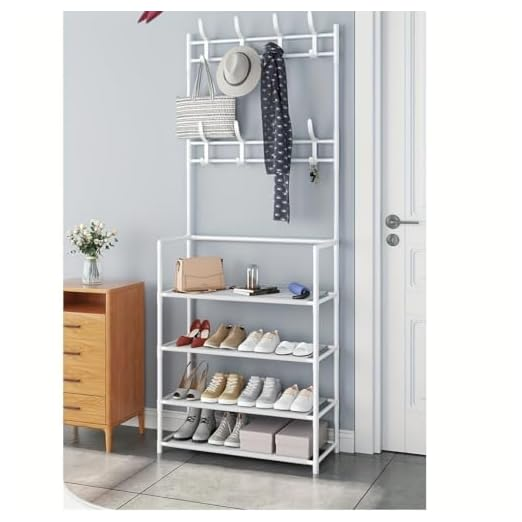




GOYMFK 1pc Free Standing Shoe Rack, Multi-layer Me... (https://www.amazon.com/dp/B0CJHKVG6P) - Similarity: 0.57


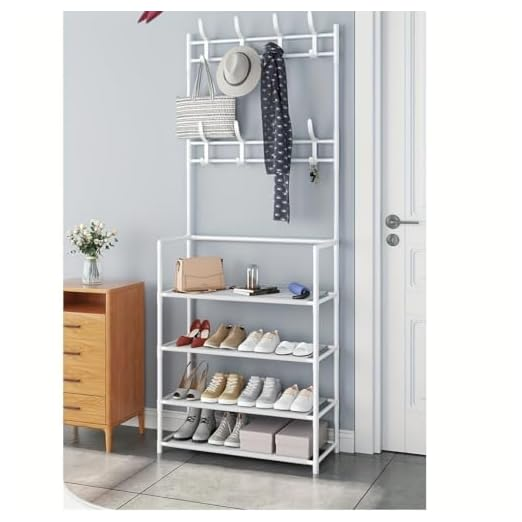




Input: black metal side table

🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b783-fc67-7f53-90a8-0d58a17444a8
FLYJOE Narrow Side Table with PU Leather Magazine ... (https://www.amazon.com/dp/B0CHYDTQKN) - Similarity: 0.59


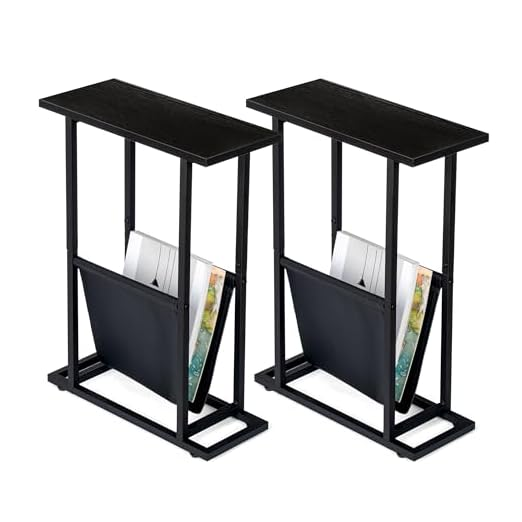




HomePop Metal Accent Table Triangle Base Round Mir... (https://www.amazon.com/dp/B08N5H868H) - Similarity: 0.57


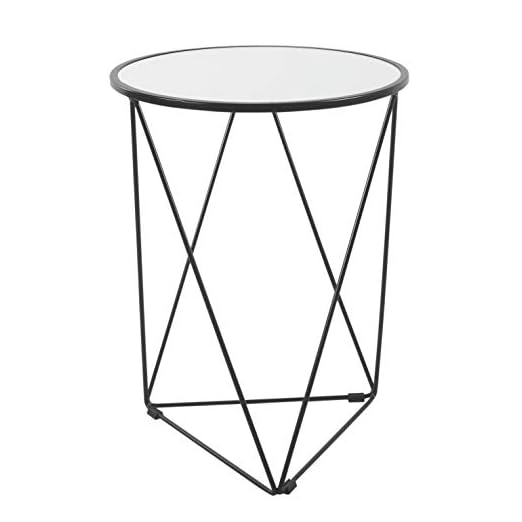




Input: doormat

🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b784-0414-7d01-975a-cae02f584a2b
Pickleball Doormat, Welcome Doormat Absorbent Non-... (https://www.amazon.com/dp/B0C1MRB2M8) - Similarity: 0.59


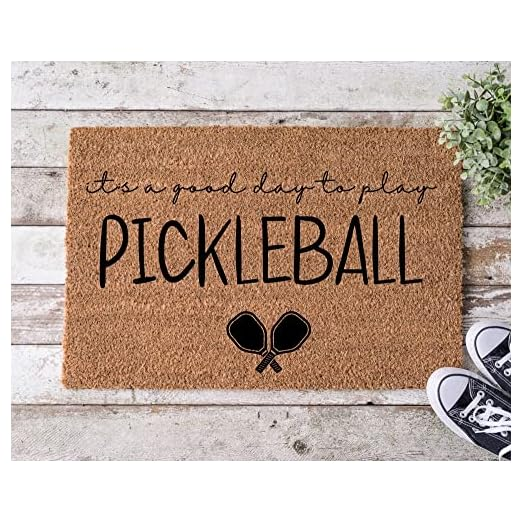




Caroline's Treasures PPD3013JMAT Enchanted Garden ... (https://www.amazon.com/dp/B08Q5KDSQK) - Similarity: 0.57


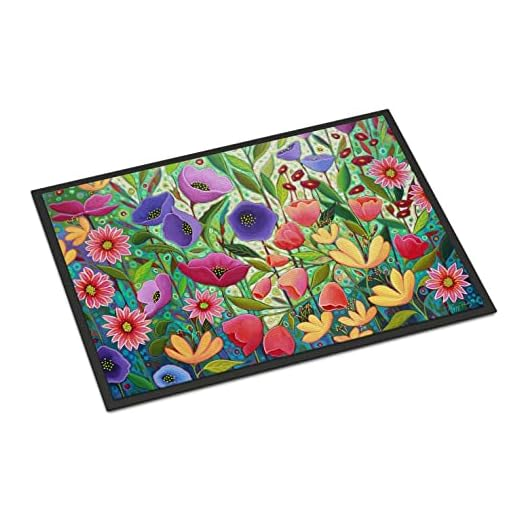




Input: step bookshelf

🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b784-0b7f-7b83-b92e-df35415625a2
Leick Home 70007-WTGD Mixed Metal and Wood Stepped... (https://www.amazon.com/dp/B098KNRNLQ) - Similarity: 0.61


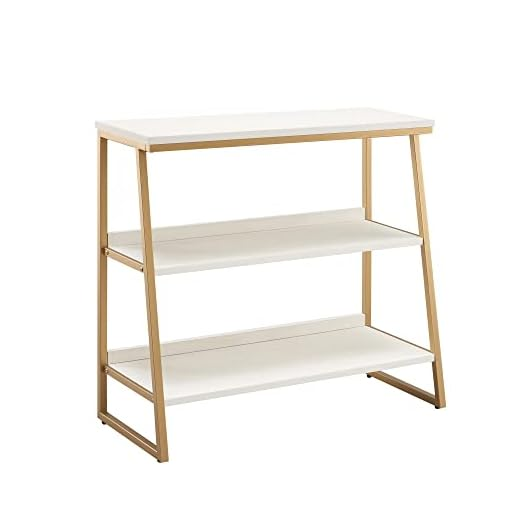




Wildkin Kids Canvas Sling Bookshelf with Storage f... (https://www.amazon.com/dp/B07GBVFZ1Y) - Similarity: 0.47


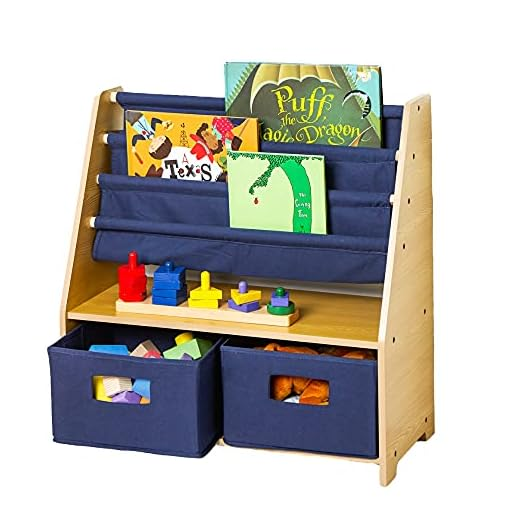




Input: ottoman

🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b784-1132-74f0-9694-37b1f9d9afcd
HomePop Home Decor | K2380-YDQY-2 | Luxury Large F... (https://www.amazon.com/dp/B0B94T1TZ1) - Similarity: 0.53


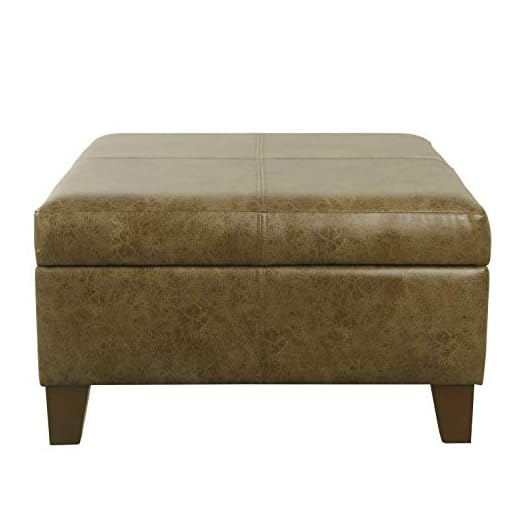




Moroccan Leather Pouf Ottoman for Living Room - Ro... (https://www.amazon.com/dp/B0CP45784G) - Similarity: 0.51


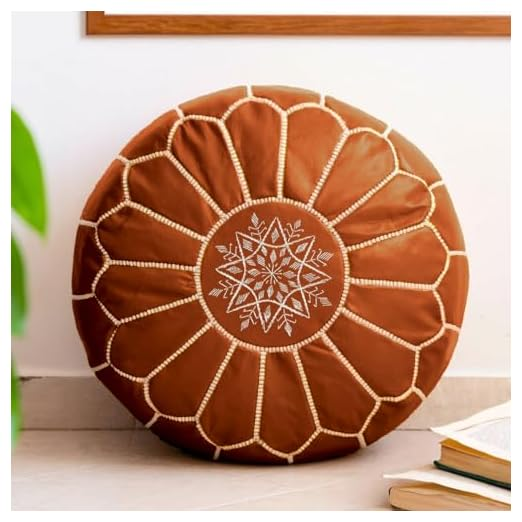

In [35]:
for i in user_inputs:
    print(f"Input: {i}\n")
    res = search_from_input_text(i, weave.ref("Tagged-and-Captioned-Embeddings:latest"))[
        "most_similar"
    ]
    for index, row in res.iterrows():
        similarity_score = row['similarity']
        if isinstance(similarity_score, np.ndarray):
            similarity_score = similarity_score[0][0]
        print(f"{row['title'][:50]}{'...' if len(row['title']) > 50 else ''} ({row['url']}) - Similarity: {similarity_score:.2f}")
        img = get_image(row['primary_image'])
        display(img)
        print("\n\n")

### Search from image

If the input is an image, we can find similar images by first turning images into captions, and embedding those captions to compare them to the already created embeddings.

In [39]:
# We'll take a mix of images: some we haven't seen and some that are already in the dataset
example_images = df.iloc[306:309]['primary_image'].to_list() + df.iloc[1:4]['primary_image'].to_list()

In [42]:
@weave.op
def search_from_image(image, image_url, search_embeddings_ref, n = 1):
    img_description = describe_image(image_url, "")["description"]
    caption = caption_image(formatted_examples, img_description)["caption"]
    res = search_from_input_text(caption, search_embeddings_ref, 1)["most_similar"].iloc[0]
    similarity_score = res["similarity"]
    if isinstance(similarity_score, np.ndarray):
        similarity_score = similarity_score[0][0]
    print(
        f"{res['title'][:50]}{'...' if len(res['title']) > 50 else ''} ({res['url']}) - Similarity: {similarity_score:.2f}"
    )
    img_res = get_image(res["primary_image"])
    return {"image": img_res}


In [43]:
for url in example_images:
    img = get_image(url)
    search_from_image(img, url, weave.ref("Tagged-and-Captioned-Embeddings:latest"))

Mimoglad Office Chair, High Back Ergonomic Desk Ch... (https://www.amazon.com/dp/B0C2YQZS69) - Similarity: 0.56
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b792-dfec-7951-bb89-fe85171f8daa
CangLong Mid Century Modern Side Chair with Wood L... (https://www.amazon.com/dp/B08RTLBD1T) - Similarity: 0.55
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b792-f869-7472-bd01-7e4933a49d76
MAEPA RV Shoe Storage for Bedside - 8 Extra Large ... (https://www.amazon.com/dp/B0C4PL1R3F) - Similarity: 0.65
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b793-1411-7122-b312-25823e0d7e88
subrtex Leather ding Room, Dining Chairs Set of 2,... (https://www.amazon.com/dp/B0B66QHB23) - Similarity: 0.76
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b793-2513-74f2-8bbe-ede0f359d170
Plant Repotting Mat MUYETOL Waterproof Transplanti... (https://www.amazon.com/dp/B0BXRTWLYK) - Similarity: 0.67
🍩 https://wandb.ai/team-jdoc/tag_caption_images/r/call/0192b793-3c5f-763

## Wrapping up


In this notebook, we explored how to leverage the multimodal capabilities of `gpt-4o-mini` to tag and caption images. By providing images along with contextual information to the model, we were able to generate tags and descriptions that can be further refined to create captions. This process has practical applications in various scenarios, particularly in enhancing search functionalities.

The search use case illustrated can be directly applied to applications such as recommendation systems, but the techniques covered in this notebook can be extended beyond items search and used in multiple use cases, for example RAG applications leveraging unstructured image data.

As a next step, you could explore using a combination of rule-based filtering with keywords and embeddings search with captions to retrieve more relevant results.